# In case of using colab 
Remember to connect to your drive and upload the dataset if you want to repeat several times  this tutorial

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content

# Download the dataset

In this occasion we are gonna use different video footage of cars to test a tracking algorithm.

[car-tracking-dataset](https://drive.google.com/drive/folders/1Xkak8cDZB2WGyJlcsinW2XZ7b7UKOZcN?usp=sharing)



In [ ]:
# !unzip video_cars.zip

# Install repositories
The repository for this hands on

```code
git clone https://github.com/LuisCossioUOH/HandsOnTracking.git
```

And install ultralytics
```code
pip install ultralytics==8.2.54
```

In [ ]:
# !git clone https://github.com/LuisCossioUOH/HandsOnTracking.git 
# %cd /content
# !pip install ultralytics==8.2.54

## Import relevant libraries

In [1]:
import os
import cv2 

import numpy as np 
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib.patches import Rectangle

from VehicleDetectionTracker.VehicleDetectionTracker import VehicleDetectionTracker


# Track dataset Dummy
1. Test the tracking dataset and check the difference between tracks and detections.
2. Draw the detections in the image 

In [57]:
from tracking_utils import TrackingEllipseGenerator 

dataset = TrackingEllipseGenerator(300,n_tracks=50,image_shape=[300,300])



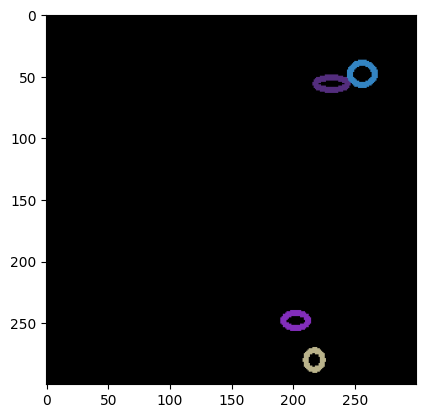

In [58]:
frame_id = 10
tracks,img = dataset.get_frame(frame_id)
plt.imshow(img)



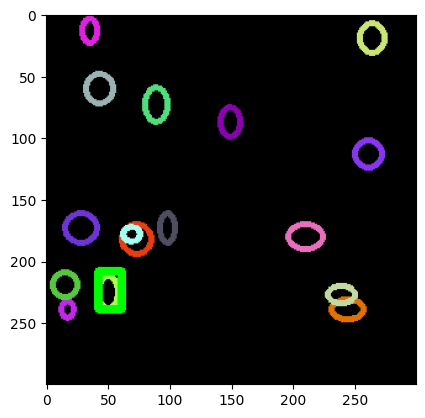

In [61]:
frame_id = 100
tracks, image, dets = dataset.get_frame_and_detections(frame_id)

color = (0,255,0)
thickness = 5
point1 = dets[0,:2].astype(np.int32)
point2 = dets[0,2:4].astype(np.int32)
image = cv2.rectangle(image, point1, point2, color=color, thickness=thickness)
plt.imshow(image)

# Kalman tracking
1. Define a function calculate the L2 distance between a vector of size [4] and a matrix of size [n,4]. And produce n distances. 
2. Modified the Tracker class to have a find_observation method. This recieves N new detections and return the closest to the currently tracked object. If there are no close detections then return and empty array. 
3. Modified the code to use the prior as the final track and increase the variance by 50% in the covariance matrix.
4. Modified to code to have an input "u" diferent than 0. The input "u" represent the acceleration. 


In [7]:
dataset = TrackingEllipseGenerator(300,n_tracks=1,image_shape=[300,300],duration_samples=[299,300],
                                   false_negative_rate=0,false_positive_rate=0.5)


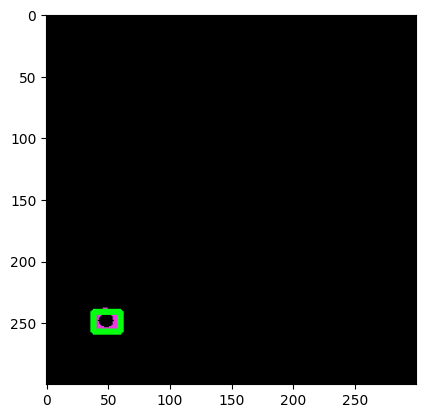

In [8]:
tracks,img,dets = dataset.get_frame_and_detections(0,draw_detection=True) 
plt.imshow(img)

In [9]:
class KalmanFilter:
    def __init__(self, A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, cov_model_diag=1.0,
                 cov_obs_diag=1.0):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.Q = np.eye(len(A)) * np.array([cov_model_diag])
        self.R = np.eye(len(C)) * np.array([cov_obs_diag])

    def prior(self, x, u):
        return self.A @ x + self.B @ u

    def observation(self, x, u):
        return self.C @ x + self.D @ u

    def posterior(self, x, prior_x, u, observation, P):
        z_prior = self.observation(x, u)  # estimation
        prior_P = self.A @ P @ self.A + self.Q
        W = prior_P @ self.C.transpose() @ np.linalg.inv(self.C @ prior_P @ self.C.transpose() + self.R)  # Kalman gain
        post_x = prior_x + W @ (observation - z_prior)  # posterior
        post_P = (np.eye(len(P)) - W @ self.C) @ prior_P  #
        return post_x, post_P

def get_kalman_filter(variance_model= 20,variance_observation=40):
    A = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                  [0, 1, 0, 0, 0, 1, 0, 0],
                  [0, 0, 1, 0, 0, 0, 1, 0],
                  [0, 0, 0, 1, 0, 0, 0, 1],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

    B = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

    C = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

    D = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])

    return KalmanFilter(A, B, C, D,variance_model, variance_observation)

kalman = get_kalman_filter()

In [10]:
def format_detections(detections: np.ndarray, speed=0):
    """
    Function to format detections into a position format
    :param detections: detection array to be formatted into a matrix of columns [x1,y1,x2,y2,x'1,y'1,x'2,y'2]. Initial
    speed is zero.
    :return:
    """
    detection = np.zeros([len(detections), 8])
    detection[:, :4] = detections[:, :4]
    detection[:, 4:] += speed
    return detection

detections_poses = format_detections(dets[:,:4]) 
print(detections_poses)

        

[[ 38. 241.  60. 257.   0.   0.   0.   0.]]


In [11]:
def calculate_iou_distance(target: np.ndarray, matrix2: np.ndarray):
    """
    Calculate IoU correlation between locations in matrices
    :param target: Position matrix array as [x1,y1,x2,y2] columns
    :param matrix2: Position matrix array as [x1,y1,x2,y2] columns
    :return:
    """
    target = np.reshape(target,[-1,4])
    inter = np.maximum(np.minimum(target[:, None, 2], matrix2[:, 2]) - np.maximum(target[:, None, 0], matrix2[:, 0]),
                       0)
    inter *= np.maximum(np.minimum(target[:, None, 3], matrix2[:, 3]) - np.maximum(target[:, None, 1], matrix2[:, 1]),
                        0)
    eps = 0.000001

    # Union Area
    w1, h1 = target[:, 2] - target[:, 0], target[:, 3] - target[:, 1] + eps
    w2, h2 = matrix2[:, 2] - matrix2[:, 0], matrix2[:, 3] - matrix2[:, 1] + eps
    union = ((w1 * h1)[:, None] + w2 * h2) - inter + eps

    iou = inter / union
    return iou

def calculate_distance(target: np.ndarray, matrix2: np.ndarray):
    """
    Calculate the distance between the target vector and some detection matrix
    :param target: Position matrix array as [x1,y1,x2,y2] columns
    :param matrix2: Position matrix array as [x1,y1,x2,y2] columns
    :return:
    """


class Tracker:
    def __init__(self,initial_position,kalman_filter:KalmanFilter,initial_covariance = 10):
        self.target = initial_position 
        self.tracks = [initial_position.copy()]
        self.kalman = kalman_filter
        self.covariance_target = np.eye(8) * initial_covariance

    def find_observation(self,new_detections,threshold=80):
        ...
        
    def process_frame(self,new_detections):
        observation = self.find_observation(new_detections)
        u = np.zeros([4])
        prior_location = self.kalman.prior(self.target,u)
        if len(observation) > 0:
            observation = observation[0,:]
            posterior_location, updated_covariance =  self.kalman.posterior(x=self.target,
                                                                                    prior_x = prior_location,
                                                                                    u = np.zeros([4]),
                                                                                    observation = observation,
                                                                                    P = self.covariance_target)
            self.covariance_target = updated_covariance
            self.target = posterior_location
            self.tracks.append(posterior_location.copy())




    def plot_tracking_position(self,img,color=(0,0.6,0.05)):

        fig, ax = plt.subplots()
        p1 = self.target[:2]
        wh = self.target[2:4] - self.target[:2]
        ax.add_patch(Rectangle(p1.tolist(), wh[0], wh[1],
                               edgecolor = 'red',
                               facecolor = 'blue',
                               fill=False,
                               lw=2))
        
        
        
        variance_x = self.covariance_target[0,0]
        variance_y = self.covariance_target[1,1]
        range_variance1 = np.array([np.sqrt(variance_x),np.sqrt(variance_y)])
        variance_x = self.covariance_target[2,2]
        variance_y = self.covariance_target[3,3]
        range_variance2 = np.array([np.sqrt(variance_x),np.sqrt(variance_y)])
        p1 = self.target[:2] - range_variance1
        p2 = self.target[2:4] + range_variance2
        wh = p2 - p1

        
        #create simple line plot
        ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        #add rectangle to plot

        ax.add_patch(Rectangle(p1.tolist(), wh[0], wh[1],
                               edgecolor = color,
                               fill=False,
                               linestyle ='--',
                               lw=2))
tracker = Tracker(detections_poses[0,:],kalman)
id_frame = 0

In [12]:
id_frame += 1 
tracks,img,dets = dataset.get_frame_and_detections(id_frame,draw_detection=True) 
# plt.imshow(img)
# plt.show()
tracker.process_frame(dets)
tracker.plot_tracking_position(img)


TypeError: object of type 'NoneType' has no len()

# Tracking cars

In [21]:
tracker = VehicleDetectionTracker('yolov8n.pt')
path_folder = '../video_cars/car000206/'

## a) Count how many cars appear in each video

In [126]:
images = [file for file in sorted(os.listdir(path_folder))]
path_images = [os.path.join(path_folder,image) for image in images]
idx_img = 0



0: 384x640 5 cars, 1 truck, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


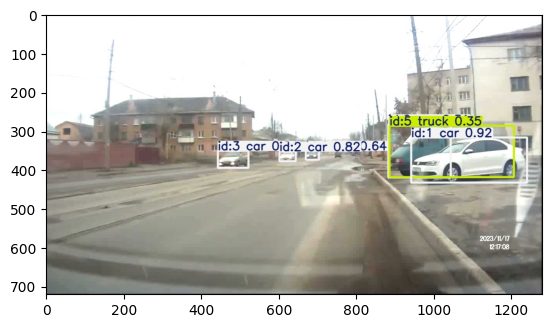

In [127]:
image_path = path_images[idx_img]
frame = cv2.imread(image_path)
timestamp = datetime.now()
response = tracker.process_frame(frame, timestamp,verbose=True)
if 'annotated_frame_base64' in response:
    annotated_frame = tracker._decode_image_base64(response['annotated_frame_base64'])
    if annotated_frame is not None:
        # Display the annotated frame in a window
        plt.imshow(cv2.cvtColor(annotated_frame,cv2.COLOR_BGR2RGB))
idx_img += 1


0: 384x640 4 cars, 4.9ms
Speed: 1.4ms preprocess, 4.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


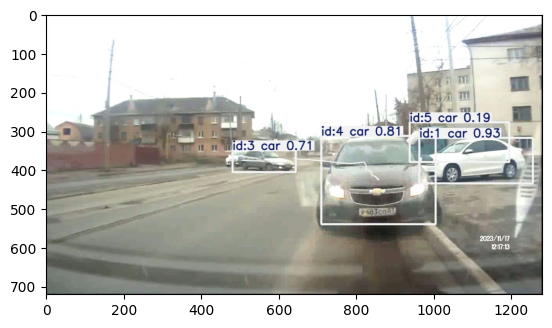

In [172]:
image_path = path_images[idx_img]
frame = cv2.imread(image_path)
timestamp = datetime.now()
response = tracker.process_frame(frame, timestamp,verbose=True)
if 'annotated_frame_base64' in response:
    annotated_frame = tracker._decode_image_base64(response['annotated_frame_base64'])
    if annotated_frame is not None:
        # Display the annotated frame in a window
        plt.imshow(cv2.cvtColor(annotated_frame,cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
idx_img += 1

In [6]:
ids_found = []
for i in range(idx_img,len(path_images)):
    timestamp = datetime.now()
    response = tracker.process_frame(frame, timestamp,verbose=False)
    for car in response['detected_vehicles']: 
        if not (car['vehicle_id'] in ids_found): 
            ids_found += [car['vehicle_id']]

print("N cars found: ",len(ids_found))

N cars found:  8


## b) Car crash predictor
1. Define a CrashCarAlarm object that uses the responses from the tracker to predict the next position of cars and predict if its going to crash.
2. Test your approach in different videos


In [123]:
tracker = VehicleDetectionTracker('yolov8n.pt')
path_folder = '../video_cars/2011_09_26_drive_0014_sync'

In [173]:
images = [file for file in sorted(os.listdir(path_folder))]
path_images = [os.path.join(path_folder,image) for image in images]
idx_img = 0

In [174]:
class CrashCarAlarm:
    def __init__(self,args):
        pass 

    def collision_imminent(self):
        pass 

    def add_track(self,track):
        pass 

Imminent collision with target 20
Position:  [     825.16      387.17      976.87      495.61]
Direction:  [     2.8049       2.021      8.2548      8.4326]
Hit Breaks at frame 34
image: 
 video_cars/car000206/0034.png


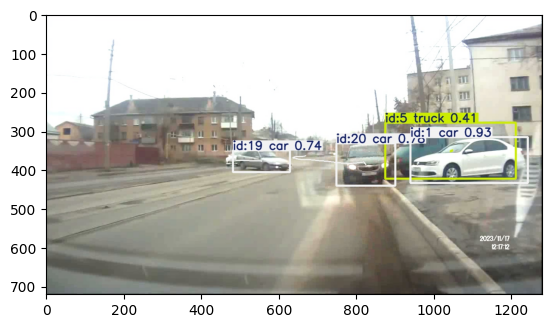

In [175]:
crash = False
for i in range(idx_img,len(path_images)):
    frame = cv2.imread(path_images[i])
    timestamp = datetime.now()
    response = tracker.process_frame(frame, timestamp,verbose=False)
    for car in response['detected_vehicles']: 
        alarm.add_track(car)
        crash = alarm.collision_imminent()
        if crash:
            print("Hit Breaks at frame {:d}".format(i))
            print("image: \n {:s}".format(path_images[i]))
            annotated_frame = tracker._decode_image_base64(response['annotated_frame_base64'])
            if annotated_frame is not None:
                # Display the annotated frame in a window
                plt.imshow(cv2.cvtColor(annotated_frame,cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
            break 
    if crash:
        break 